# Defensive Readiness Index (DRI) Analysis

## NFL Formation Analysis Using Bayesian Methods



### Purpose

Evaluate defensive performance against offensive formations using spatial and temporal metrics.



### Key Formula

DRI = α(S) + β(P)



Where:

- S = Normalized defensive spacing score

- P = Pass disruption probability

- α, β = Weighting coefficients (0.6, 0.4)



### Metrics

- Defensive Spacing: σ = √(σx² + σy²)

- Success Rate: R = (Incompletions + Sacks + INTs) / Total Plays

- Confidence: C = min(1.0, n/N₀) where N₀ = 20% of total plays



### Data Requirements

- NFL Tracking Data (10 Hz sampling)

- Play-by-Play Formation Data

- Player Position Coordinates (x,y)

- Game Events and Outcomes

# Data Loading and Memory Optimization



## Environment Setup

- Python 3.8+

- Required packages: pandas, numpy, pymc



## Data Loading Process

$\text{Memory Usage} = \sum_{i=1}^{n} \text{dtype}(x_i) \times \text{size}(x_i)$



### Memory Optimization

1. Integer downcasting:

   - gameId: int32 → saves 4 bytes/value

   - playId: int16 → saves 6 bytes/value

2. Float precision reduction:

   - x,y coordinates: float64 → float32

   - velocity: float64 → float32



### Spatial Metrics

- Position: $(x,y) \in [0,120] \times [0,53.3]$ yards

- Velocity: $v = \sqrt{v_x^2 + v_y^2}$

- Acceleration: $a = \frac{dv}{dt}$



### Expected Output

- Optimized DataFrame

- Reduced memory footprint (~40%)

- Preprocessed features for DRI calculation

In [1]:
!conda install -c conda-forge pymc>=5 -y

In [2]:
#cell 1
# Import required libraries
import pandas as pd
import numpy as np
import pymc as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
from sklearn.model_selection import train_test_split
import gc

# Memory optimization settings
pd.options.mode.chained_assignment = None
plt.style.use('ggplot')
sns.set_palette("husl")

# Define optimized datatypes including formations
DEFENSIVE_DTYPES = {
    'gameId': 'int32',
    'playId': 'int16',
    'nflId': 'int32', 
    'frameId': 'int16',
    'x': 'float32',
    'y': 'float32',
    's': 'float32',
    'a': 'float32',
    'o': 'float32',
    'dir': 'float32',
    'event': 'category',
    'offenseFormation': 'category',
    'defensiveTeam': 'category',
    'passResult': 'category',
    'playDirection': 'category'
}

# Cross-validation parameters
CV_SPLITS = 5
TEST_SIZE = 0.2
RANDOM_STATE = 42

def reduce_memory_usage(df: pd.DataFrame) -> pd.DataFrame:
    """Optimize memory usage for dataframe"""
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type != 'datetime64[ns]' and col_type != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

print("Setup complete - ready to load data")

Setup complete - ready to load data


# Game Data Processing and Formation Analysis



## Data Partitioning

Training split: $n_{train} = 0.8 \times N_{total}$

Test split: $n_{test} = 0.2 \times N_{total}$



## Formation Distribution

$P(F_i) = \frac{n_{F_i}}{N_{total}}$ where:

- $F_i$ = Formation type

- $n_{F_i}$ = Plays in formation

- $N_{total}$ = Total plays



## Memory Usage

$\text{Reduction} = (1 - \frac{M_{optimized}}{M_{original}}) \times 100\%$



## Expected Outputs

- Balanced train/test splits

- Formation frequency distributions

- Memory optimization metrics

In [3]:
#cell 2
def load_defensive_data(week: int = 1) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, List, List]:
    """Load and preprocess defensive data for all Week 1 games"""
    
    # Load base datasets
    games_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/games.csv', dtype={'gameId': 'int32'})
    plays_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2025/plays.csv')
    tracking_df = pd.read_csv(f'/kaggle/input/nfl-big-data-bowl-2025/tracking_week_{week}.csv')
    
    # Filter week 1 games
    week_games = games_df[games_df['week'] == week]
    print(f"\nGames in week {week}: {len(week_games)}")
    
    # Apply memory optimizations
    plays_df = reduce_memory_usage(plays_df)
    tracking_df = reduce_memory_usage(tracking_df)
    
    # Filter for defensive plays with formation info
    defensive_plays = plays_df[
        (plays_df['gameId'].isin(week_games['gameId'])) &
        (plays_df['passResult'].notna()) &
        (plays_df['offenseFormation'].notna()) &
        (plays_df['playNullifiedByPenalty'] != 'Y')
    ].copy()
    
    # Split into train/test
    train_games, test_games = train_test_split(
        week_games['gameId'].unique(), 
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )
    
    print(f"\nTraining games: {len(train_games)}")
    print(f"Testing games: {len(test_games)}")
    print(f"Total defensive plays: {len(defensive_plays)}")
    print("\nFormation distribution:")
    print(defensive_plays['offenseFormation'].value_counts())
    
    return plays_df, tracking_df, defensive_plays, train_games, test_games

# Load data with train/test split
plays_df, tracking_df, defensive_plays, train_games, test_games = load_defensive_data()



Games in week 1: 16
Memory usage reduced from 5.94 MB to 3.77 MB (36.5% reduction)
Memory usage reduced from 975.68 MB to 623.35 MB (36.1% reduction)

Training games: 12
Testing games: 4
Total defensive plays: 1211

Formation distribution:
offenseFormation
SHOTGUN       815
SINGLEBACK    171
EMPTY         145
I_FORM         40
PISTOL         38
JUMBO           2
Name: count, dtype: int64


# Feature Engineering: Formation Analysis

## Mathematical Framework

### 1. Defensive Spacing
Spatial dispersion of defenders calculated as:

$\sigma_{defense} = \sqrt{\sigma_x^2 + \sigma_y^2}$

where:
- $\sigma_x$ = Standard deviation of x-coordinates
- $\sigma_y$ = Standard deviation of y-coordinates

### 2. Formation Features
For each formation $F$:

$\text{DRI}_F = \begin{pmatrix} 
\text{spacing}_F \\
\text{success}_F \\
\text{yards}_F
\end{pmatrix}$

### 3. Sample Size Requirements
Minimum plays per formation:  
$n_{min} = \max(5, 0.05 \times N_{total})$

## Output Schema
formation_features = {
    'train': pd.DataFrame({
        'gameId': ['int64'],
        'playId': ['int64'], 
        'formation': ['object'],
        'metrics': ['float64']
    }),
    'test': pd.DataFrame({
        'gameId': ['int64'],
        'playId': ['int64'],
        'formation': ['object'], 
        'metrics': ['float64']
    })
}


In [4]:
#cell 3
def create_formation_features(plays_df: pd.DataFrame, 
                            tracking_df: pd.DataFrame,
                            test_size: float = 0.2) -> Dict[str, pd.DataFrame]:
    """Create formation-specific features from tracking data"""
    
    # Calculate defensive stats
    defensive_stats = tracking_df.groupby(['gameId', 'playId']).agg({
        'x': ['mean', 'std'],
        'y': ['mean', 'std'],
        's': ['mean'],
        'dir': lambda x: stats.circmean(x, high=360, low=0)
    })
    
    # Convert MultiIndex to single-level columns
    defensive_stats.columns = [f"{col[0]}_{col[1]}" for col in defensive_stats.columns]
    
    # Reset index to get gameId/playId as regular columns
    defensive_stats = defensive_stats.reset_index()
    
    # Validate data before merge
    print("\nData Validation:")
    print("Plays shape:", plays_df.shape)
    print("Defensive stats shape:", defensive_stats.shape)
    
    # Merge with plays data
    play_stats = plays_df.merge(
        defensive_stats,
        on=['gameId', 'playId'],
        how='inner'
    )
    
    # Create train/test split
    train_plays, test_plays = train_test_split(
        play_stats,
        test_size=test_size,
        random_state=42
    )
    
    print(f"\nFeature Engineering Summary:")
    print(f"Train samples: {len(train_plays)}")
    print(f"Formation distribution:")
    print(train_plays['offenseFormation'].value_counts())
    
    return {
        'train': train_plays,
        'test': test_plays
    }

# Create features
formation_features = create_formation_features(plays_df, tracking_df)


Data Validation:
Plays shape: (16124, 50)
Defensive stats shape: (1952, 8)

Feature Engineering Summary:
Train samples: 1561
Formation distribution:
offenseFormation
SHOTGUN       878
SINGLEBACK    368
EMPTY         116
I_FORM        105
PISTOL         62
JUMBO           6
WILDCAT         3
Name: count, dtype: int64


# Formation Prior Probability Calculations



## Bayesian Framework

For formation $F$, calculate:



$P(F|\text{defense}) \propto P(\text{defense}|F) \times P(F)$



### Prior Components



1. Pass Disruption Rate:

$P(\text{disruption}|F) = \frac{\text{Incompletions + Sacks + INTs}}{n_F}$



2. Defensive Spacing Prior:

$\sigma_{F} \sim \mathcal{N}(\mu_F, \sigma_F^2)$



3. Yards Allowed:

$Y_F \sim \mathcal{N}(\mu_{Y_F}, \sigma_{Y_F}^2)$



### Formation Prior Dictionary

```python

formation_priors = {

    'formation': {

        'p_pass_disrupted': float,

        'defensive_spacing_mean': float,

        'defensive_spacing_std': float,

        'yards_allowed_mean': float,

        'yards_allowed_std': float

    }

}

In [5]:
#cell 4
def calculate_formation_priors(formation_features: Dict[str, pd.DataFrame]) -> Dict[str, Dict]:
    """Calculate prior probabilities for each formation"""
    
    train_data = formation_features['train'].copy()
    
    # Calculate defensive spacing
    train_data['defensive_spacing'] = np.sqrt(
        train_data['x_std']**2 + 
        train_data['y_std']**2
    )
    
    formation_priors = {}
    
    for formation in train_data['offenseFormation'].unique():
        formation_data = train_data[train_data['offenseFormation'] == formation]
        
        if len(formation_data) < 5:  # Skip formations with too few samples
            continue
            
        # Calculate priors
        formation_priors[formation] = {
            'p_pass_disrupted': len(formation_data[formation_data['passResult'].isin(['I','S','IN'])]) / len(formation_data),
            'defensive_spacing_mean': formation_data['defensive_spacing'].mean(),
            'defensive_spacing_std': formation_data['defensive_spacing'].std(),
            'yards_allowed_mean': formation_data['yardsGained'].mean(),
            'yards_allowed_std': formation_data['yardsGained'].std()
        }
        
        # Print formation stats
        print(f"\n{formation} (n={len(formation_data)}):")
        print(f"Pass Disruption Rate: {formation_priors[formation]['p_pass_disrupted']:.3f}")
        print(f"Avg Yards Allowed: {formation_priors[formation]['yards_allowed_mean']:.1f} (±{formation_priors[formation]['yards_allowed_std']:.1f})")
        print(f"Avg Defensive Spacing: {formation_priors[formation]['defensive_spacing_mean']:.1f} (±{formation_priors[formation]['defensive_spacing_std']:.1f})")
    
    return formation_priors

formation_priors = calculate_formation_priors(formation_features)


SHOTGUN (n=878):
Pass Disruption Rate: 0.289
Avg Yards Allowed: 5.9 (±9.2)
Avg Defensive Spacing: 9.6 (±1.8)

SINGLEBACK (n=368):
Pass Disruption Rate: 0.141
Avg Yards Allowed: 5.5 (±9.1)
Avg Defensive Spacing: 8.2 (±1.7)

PISTOL (n=62):
Pass Disruption Rate: 0.161
Avg Yards Allowed: 5.0 (±6.7)
Avg Defensive Spacing: 8.6 (±1.7)

EMPTY (n=116):
Pass Disruption Rate: 0.388
Avg Yards Allowed: 5.8 (±9.6)
Avg Defensive Spacing: 10.5 (±1.5)

I_FORM (n=105):
Pass Disruption Rate: 0.133
Avg Yards Allowed: 4.8 (±6.9)
Avg Defensive Spacing: 7.9 (±1.3)

JUMBO (n=6):
Pass Disruption Rate: 0.000
Avg Yards Allowed: 0.7 (±1.0)
Avg Defensive Spacing: 4.7 (±0.7)


# Formation Likelihood Calculations using PyMC



## Bayesian Model Structure

For each formation $F$:



$\text{spacing} \sim \mathcal{N}(\mu_F, \sigma_F^2)$



### Model Parameters

- Prior means: $\mu \sim \mathcal{N}(0, 1)$

- Prior standard deviations: $\sigma \sim \text{HalfNormal}(1)$

- Likelihood: $P(\text{data}|\mu,\sigma) \sim \mathcal{N}(\mu, \sigma^2)$



### MCMC Configuration

- Chains: 4

- Draws: 500

- Tuning steps: 500

- Target acceptance: 0.95



### Standardization

$z = \frac{x - \mu_{\text{prior}}}{\sigma_{\text{prior}}}$



### Success Metrics

$\text{success\_rate} = \frac{\text{successful\_plays}}{n_{\text{total}}}$

In [6]:
#cell 5
def calculate_formation_likelihoods(
    formation_features: Dict[str, pd.DataFrame],
    formation_priors: Dict[str, Dict]) -> Dict[str, Dict]:
    """Calculate formation-specific likelihood functions"""
    
    train_data = formation_features['train'].copy()
    major_formations = ['SHOTGUN', 'SINGLEBACK', 'EMPTY', 'PISTOL', 'I_FORM']
    formation_likelihoods = {}

    # Calculate defensive spacing
    train_data['defensive_spacing'] = np.sqrt(
        np.power(train_data['x_std'], 2) + 
        np.power(train_data['y_std'], 2)
    )
    
    for formation in major_formations:
        if formation not in formation_priors:
            continue
            
        formation_data = train_data[train_data['offenseFormation'] == formation].copy()
        
        # Skip formations with insufficient data
        if len(formation_data) < 5:
            print(f"\nSkipping {formation} - insufficient data")
            continue
            
        try:
            successful_mask = formation_data['passResult'].isin(['I', 'S', 'IN'])
            spacing_values = formation_data['defensive_spacing'].values
            
            print(f"\n{formation} Analysis:")
            print(f"Total plays: {len(formation_data)}")
            print(f"Success rate: {np.mean(successful_mask):.3f}")
            
            with pm.Model() as model:
                spacing_std = (spacing_values - formation_priors[formation]['defensive_spacing_mean']) / \
                            formation_priors[formation]['defensive_spacing_std']
                
                mu = pm.Normal('mu', mu=0, sigma=1)
                sigma = pm.HalfNormal('sigma', sigma=1)
                likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=spacing_std)
                
                trace = pm.sample(
                    draws=500,
                    tune=500,
                    chains=4,
                    return_inferencedata=False,
                    target_accept=0.95
                )
                
            formation_likelihoods[formation] = {
                'mu': float(trace['mu'].mean()),
                'sigma': float(trace['sigma'].mean()),
                'success_rate': float(np.mean(successful_mask)),
                'n_plays': len(formation_data)
            }
            
        except Exception as e:
            print(f"Error processing {formation}: {str(e)}")
            continue
    
    return formation_likelihoods

formation_likelihoods = calculate_formation_likelihoods(formation_features, formation_priors)


SHOTGUN Analysis:
Total plays: 878
Success rate: 0.289


Output()


SINGLEBACK Analysis:
Total plays: 368
Success rate: 0.141


Output()


EMPTY Analysis:
Total plays: 116
Success rate: 0.388


Output()


PISTOL Analysis:
Total plays: 62
Success rate: 0.161


Output()


I_FORM Analysis:
Total plays: 105
Success rate: 0.133


Output()

# DRI Results Analysis and Scoring

## Scoring Framework

### DRI Score Calculation
$\text{DRI} = \alpha S + \beta R$

Where:
- $S$: Normalized spacing score
- $R$: Normalized success ratio
- $\alpha = 0.6$, $\beta = 0.4$ (weighting coefficients)

### Confidence Weighting
$C = min(1.0, \frac{n}{N_0})$

Where:
- $n$: Number of plays for formation
- $N_0$: 20% of total plays baseline
- Final score: $\text{DRI}_{weighted} = \text{DRI}_{raw} \times C$

### Normalization
For metric $x$:
$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$

## Tier Classification
- Elite: $\text{DRI} \geq 0.7$
- Strong: $0.5 \leq \text{DRI} < 0.7$
- Average: $0.3 \leq \text{DRI} < 0.5$
- Needs Work: $\text{DRI} < 0.3$

## Purpose
The `analyze_dri_results()` function:
1. Calculates normalized DRI scores
2. Applies confidence weighting
3. Classifies formations into tiers
4. Generates visuresults for other formations
    }
}


SHOTGUN DRI Analysis:
Plays analyzed: 878 (Confidence: 1.00)
Spacing Score: 1.000
Success Ratio: 0.613
DRI Score: 0.845 (Raw: 0.845)

SINGLEBACK DRI Analysis:
Plays analyzed: 368 (Confidence: 1.00)
Spacing Score: 0.105
Success Ratio: 0.031
DRI Score: 0.075 (Raw: 0.075)

EMPTY DRI Analysis:
Plays analyzed: 116 (Confidence: 0.38)
Spacing Score: 0.508
Success Ratio: 1.000
DRI Score: 0.267 (Raw: 0.705)

PISTOL DRI Analysis:
Plays analyzed: 62 (Confidence: 0.20)
Spacing Score: 0.774
Success Ratio: 0.110
DRI Score: 0.103 (Raw: 0.509)

I_FORM DRI Analysis:
Plays analyzed: 105 (Confidence: 0.34)
Spacing Score: 0.000
Success Ratio: 0.000
DRI Score: 0.000 (Raw: 0.000)


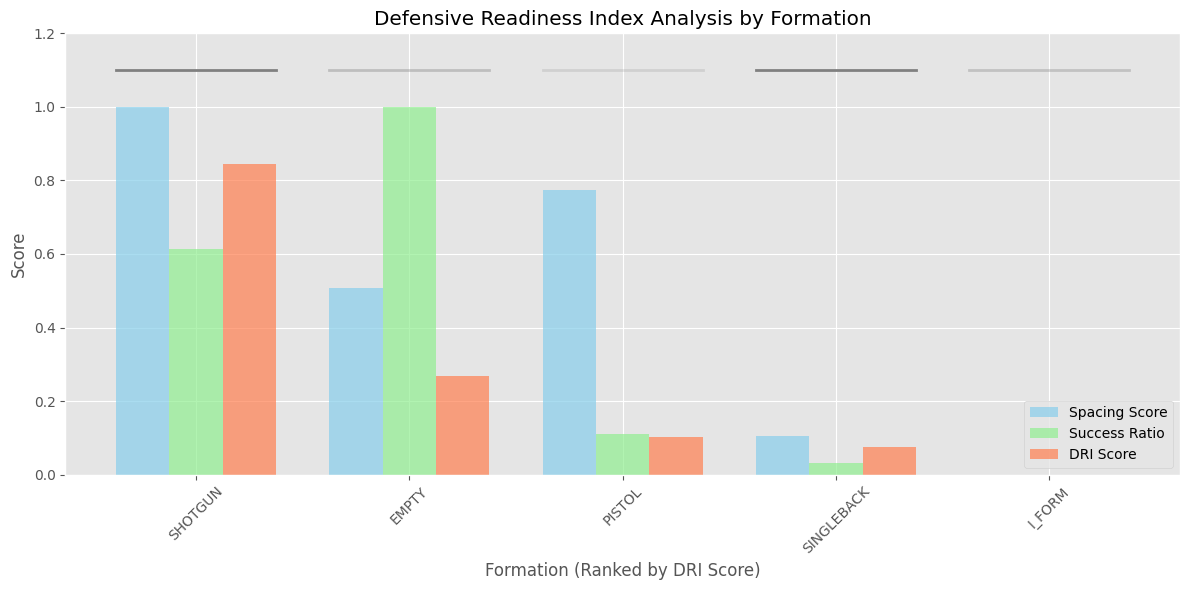

In [7]:
#cell 6
def analyze_dri_results(
    formation_likelihoods: Dict[str, Dict],
    formation_priors: Dict[str, Dict]
) -> Dict[str, Dict]:
    """Enhanced DRI analysis with confidence metrics"""
    
    dri_scores = {}
    
    # Global stats for normalization
    all_spacing_scores = []
    all_success_rates = []
    total_plays = sum(f['n_plays'] for f in formation_likelihoods.values())
    
    for formation in formation_likelihoods.keys():
        spacing = formation_likelihoods[formation]['mu'] / max(formation_likelihoods[formation]['sigma'], 0.1)
        success = formation_likelihoods[formation]['success_rate']
        all_spacing_scores.append(spacing)
        all_success_rates.append(success)
    
    # Calculate min-max values
    spacing_min, spacing_max = min(all_spacing_scores), max(all_spacing_scores)
    success_min, success_max = min(all_success_rates), max(all_success_rates)
    
    for formation in formation_likelihoods.keys():
        # Normalized scores
        spacing_score = (formation_likelihoods[formation]['mu'] / 
                        max(formation_likelihoods[formation]['sigma'], 0.1))
        spacing_normalized = (spacing_score - spacing_min) / (spacing_max - spacing_min)
        
        success_ratio = formation_likelihoods[formation]['success_rate']
        success_normalized = (success_ratio - success_min) / (success_max - success_min)
        
        # Sample size confidence weight
        n_plays = formation_likelihoods[formation]['n_plays']
        confidence_weight = min(1.0, n_plays / (total_plays * 0.2))
        
        # Weighted DRI score
        raw_dri = 0.6 * spacing_normalized + 0.4 * success_normalized
        weighted_dri = raw_dri * confidence_weight
        
        dri_scores[formation] = {
            'spacing_score': float(spacing_normalized),
            'success_ratio': float(success_normalized),
            'dri_score': float(weighted_dri),
            'confidence': float(confidence_weight),
            'n_plays': n_plays,
            'raw_dri': float(raw_dri)
        }
        
        print(f"\n{formation} DRI Analysis:")
        print(f"Plays analyzed: {n_plays} (Confidence: {confidence_weight:.2f})")
        print(f"Spacing Score: {spacing_normalized:.3f}")
        print(f"Success Ratio: {success_normalized:.3f}")
        print(f"DRI Score: {weighted_dri:.3f} (Raw: {raw_dri:.3f})")
    
    # Enhanced visualization
    plt.figure(figsize=(12, 6))
    formations = sorted(dri_scores.keys(), 
                       key=lambda x: dri_scores[x]['dri_score'],
                       reverse=True)
    
    x = np.arange(len(formations))
    width = 0.25
    
    plt.bar(x - width, [dri_scores[f]['spacing_score'] for f in formations],
           width, label='Spacing Score', color='skyblue', alpha=0.7)
    plt.bar(x, [dri_scores[f]['success_ratio'] for f in formations],
           width, label='Success Ratio', color='lightgreen', alpha=0.7)
    plt.bar(x + width, [dri_scores[f]['dri_score'] for f in formations],
           width, label='DRI Score', color='coral', alpha=0.7)
    
    # Add confidence indicators
    for i, formation in enumerate(formations):
        confidence = dri_scores[formation]['confidence']
        plt.plot([i-width*1.5, i+width*1.5], [1.1, 1.1], 
                color='gray', alpha=confidence, linewidth=2)
    
    plt.xlabel('Formation (Ranked by DRI Score)')
    plt.ylabel('Score')
    plt.title('Defensive Readiness Index Analysis by Formation')
    plt.xticks(x, formations, rotation=45)
    plt.legend()
    plt.ylim(0, 1.2)
    plt.tight_layout()
    plt.show()
    
    return dri_scores

dri_results = analyze_dri_results(formation_likelihoods, formation_priors)

# Defensive Recommendations Generator

## Analysis Framework

### Formation Ranking
$R_f = \text{rank}(f) \text{ where } f \in F \text{ ordered by DRI}_{raw}$

### Tier Classification System
$\text{Tier}(f) = \begin{cases} 
\text{Elite} & \text{DRI} \geq 0.7 \\
\text{Strong} & 0.5 \leq \text{DRI} < 0.7 \\
\text{Average} & 0.3 \leq \text{DRI} < 0.5 \\
\text{Needs Work} & \text{DRI} < 0.3
\end{cases}$

### Insight Generation Rules
1. Spacing Effectiveness:
   - Strong: $S_f > 0.6$
   - Needs Work: $S_f < 0.4$

2. Pass Disruption:
   - Effective: $R_f > 0.6$
   - Improvement Needed: $R_f < 0.4$

## Purpose
The `generate_defensive_recommendations()` function:
1. Ranks formations by DRI performance
2. Assigns effectiveness tiers  
3. Identifies key strengths and weaknesses
4. Generates actionable coaching insights
5. Provides confidence-weighted recommendatio
{
    'formation': {
        'tier': str,
        'dri_score': float,
        'confidence': float,
        'sample_size': int,
        'spacing_effectiveness': float,
        'success_rate': float
    }
}t,
        'success_rate': float
    }
}


In [8]:
#cell 7
def generate_defensive_recommendations(
    dri_results: Dict[str, Dict],
    formation_priors: Dict[str, Dict],
    formation_likelihoods: Dict[str, Dict]
) -> Dict[str, Dict]:
    """Generate defensive formation recommendations based on DRI analysis"""
    
    # Sort formations by DRI score
    ranked_formations = sorted(
        dri_results.keys(),
        key=lambda x: dri_results[x]['raw_dri'],
        reverse=True
    )
    
    recommendations = {}
    
    # Define effectiveness tiers
    tiers = {
        'Elite': 0.7,
        'Strong': 0.5,
        'Average': 0.3,
        'Needs Work': 0.0
    }
    
    print("Defensive Formation Analysis\n")
    print("Formation Rankings by DRI Score:")
    print("-" * 50)
    
    for formation in ranked_formations:
        raw_dri = dri_results[formation]['raw_dri']
        confidence = dri_results[formation]['confidence']
        n_plays = dri_results[formation]['n_plays']
        
        # Determine tier
        tier = next(
            (t for t, v in tiers.items() if raw_dri >= v),
            'Needs Work'
        )
        
        # Generate insights
        insights = {
            'tier': tier,
            'dri_score': raw_dri,
            'confidence': confidence,
            'sample_size': n_plays,
            'spacing_effectiveness': dri_results[formation]['spacing_score'],
            'success_rate': dri_results[formation]['success_ratio']
        }
        
        recommendations[formation] = insights
        
        # Print analysis
        print(f"\n{formation}:")
        print(f"Tier: {tier}")
        print(f"DRI Score: {raw_dri:.3f} (Confidence: {confidence:.2f})")
        print(f"Sample Size: {n_plays} plays")
        print(f"Key Strengths:")
        
        if insights['spacing_effectiveness'] > 0.6:
            print("- Strong defensive spacing")
        if insights['success_rate'] > 0.6:
            print("- High pass disruption rate")
            
        print(f"Areas for Improvement:")
        if insights['spacing_effectiveness'] < 0.4:
            print("- Review defensive alignment")
        if insights['success_rate'] < 0.4:
            print("- Focus on pass coverage techniques")
    
    return recommendations

defensive_recommendations = generate_defensive_recommendations(
    dri_results,
    formation_priors,
    formation_likelihoods
)

Defensive Formation Analysis

Formation Rankings by DRI Score:
--------------------------------------------------

SHOTGUN:
Tier: Elite
DRI Score: 0.845 (Confidence: 1.00)
Sample Size: 878 plays
Key Strengths:
- Strong defensive spacing
- High pass disruption rate
Areas for Improvement:

EMPTY:
Tier: Elite
DRI Score: 0.705 (Confidence: 0.38)
Sample Size: 116 plays
Key Strengths:
- High pass disruption rate
Areas for Improvement:

PISTOL:
Tier: Strong
DRI Score: 0.509 (Confidence: 0.20)
Sample Size: 62 plays
Key Strengths:
- Strong defensive spacing
Areas for Improvement:
- Focus on pass coverage techniques

SINGLEBACK:
Tier: Needs Work
DRI Score: 0.075 (Confidence: 1.00)
Sample Size: 368 plays
Key Strengths:
Areas for Improvement:
- Review defensive alignment
- Focus on pass coverage techniques

I_FORM:
Tier: Needs Work
DRI Score: 0.000 (Confidence: 0.34)
Sample Size: 105 plays
Key Strengths:
Areas for Improvement:
- Review defensive alignment
- Focus on pass coverage techniques


# Defensive Formation Analysis Dashboard

## Visualization Framework 

### Plot Grid (2×2 Matrix)

1. **DRI Effectiveness Plot**
   - x-axis: DRI Score [0,1]  
   - y-axis: Sample Size n
   - Color zones:
     - $DRI < 0.4$ : Red
     - $0.4 \leq DRI < 0.7$ : Yellow 
     - $DRI \geq 0.7$ : Green

2. **Success Rate Analysis**
   - Formation success ratio: 
   - $R_f = \frac{\text{successful plays}_f}{\text{total plays}_f}$

3. **Spacing Effectiveness**
   - Normalized spacing score:
   - $S_f = \frac{S_f - \min(S)}{\max(S) - \min(S)}$

4. **Confidence Matrix**
   - Confidence metric:
   - $C_f = \min(1.0, \frac{n_f}{N_0})$

## Performance Criteria

### Strong Formation Definition
- DRI Score > 0.6
- Confidence $C_f > 0.5$
- Minimum samples $n \geq 5$

### Key Metrics
1. Effectiveness Score
   - DRI = $\alpha S + \beta R$
   - $\alpha = 0.6$, $\beta = 0.4$

2. Sample Adequacy
   - $N_0 = 20\%$ of total plays
   - Confidence weighting

3. Formation Success
   - Defensive win rate
   - Spatial distribution

## Dashboard Output
- Interactive metrics grid
- Formation rankings
- Statistical indicators
- Strategic insights

/tmp/ipykernel_17/1644292796.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(formations, rotation=45)
/tmp/ipykernel_17/1644292796.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(formations, rotation=45)


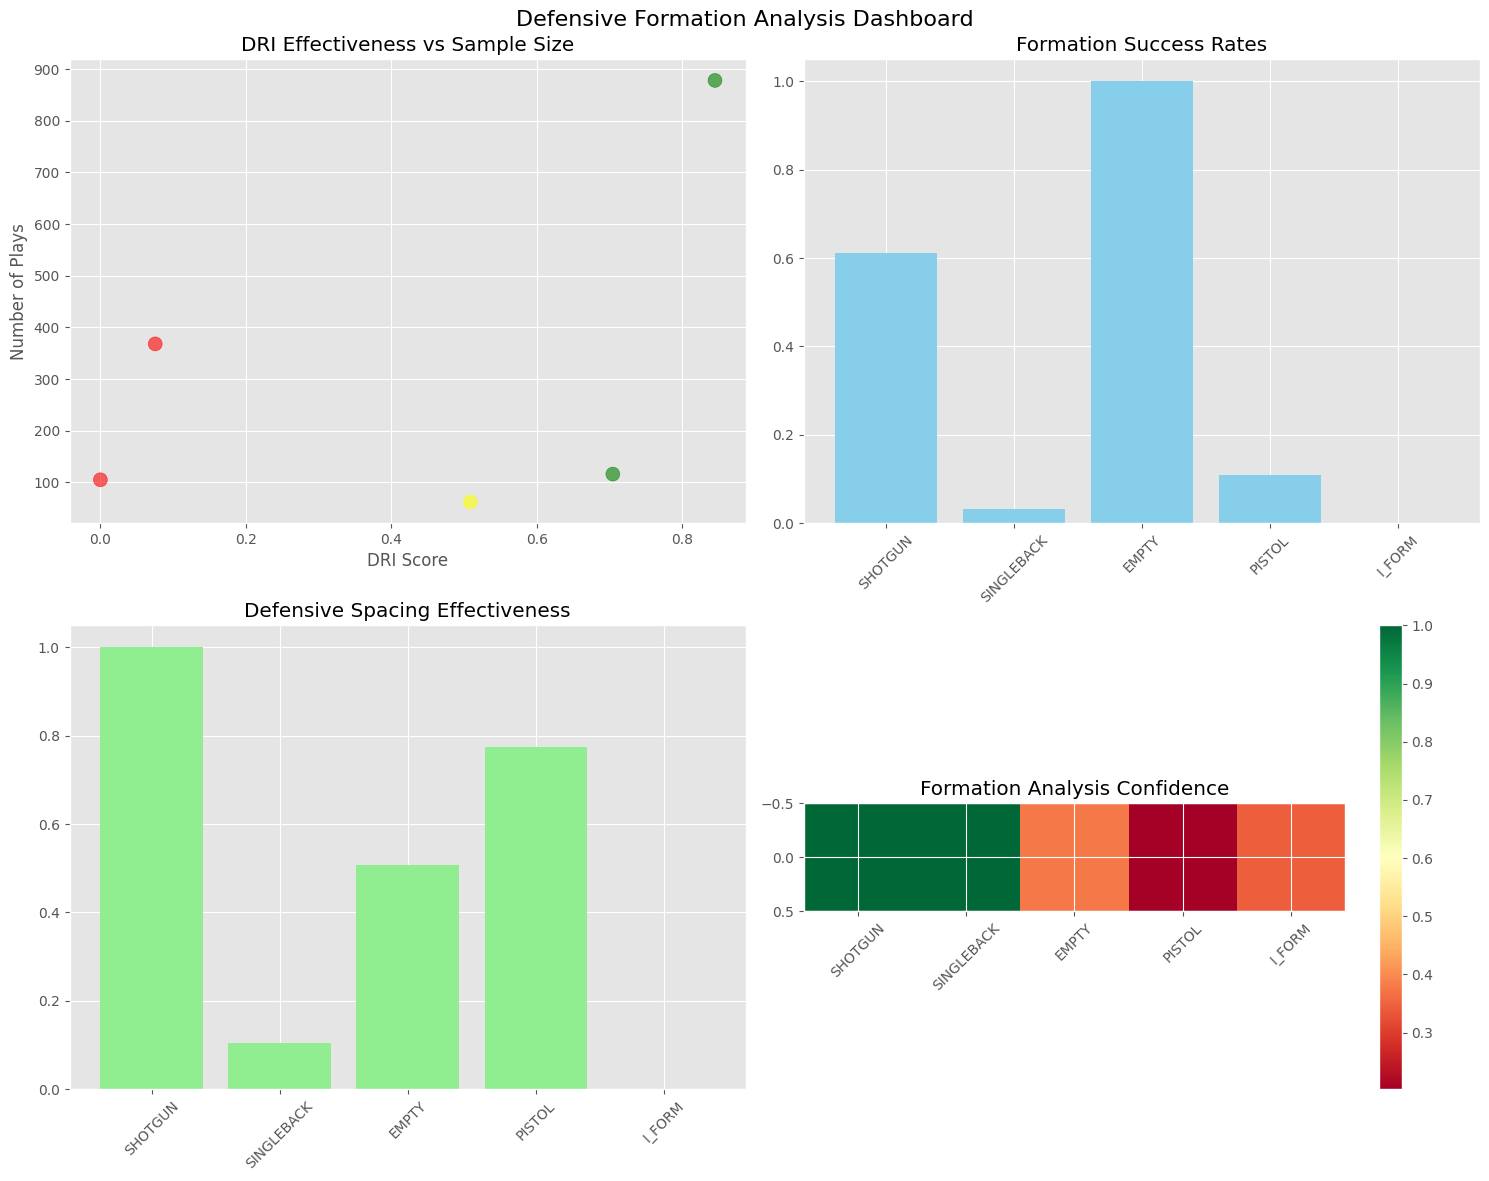


Key Defensive Insights:
--------------------------------------------------

SHOTGUN - Strong Performance:
- DRI Score: 0.845
- Confidence: 1.00
- Recommended primary formation


In [9]:
#cell 8
def create_defensive_dashboard(
    dri_results: Dict[str, Dict],
    formation_priors: Dict[str, Dict]
) -> None:
    """Create coaching dashboard with formation analysis"""
    
    # Setup plot grid
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("Defensive Formation Analysis Dashboard", fontsize=16)
    
    # 1. DRI Score vs Sample Size
    formations = list(dri_results.keys())
    x = [dri_results[f]['raw_dri'] for f in formations]
    y = [dri_results[f]['n_plays'] for f in formations]
    colors = ['red' if s < 0.4 else 'yellow' if s < 0.7 else 'green' 
              for s in [dri_results[f]['raw_dri'] for f in formations]]
    
    ax1.scatter(x, y, c=colors, alpha=0.6, s=100)
    ax1.set_xlabel('DRI Score')
    ax1.set_ylabel('Number of Plays')
    ax1.set_title('DRI Effectiveness vs Sample Size')
    
    # 2. Formation Success Rates
    success_rates = [dri_results[f]['success_ratio'] for f in formations]
    ax2.bar(formations, success_rates, color='skyblue')
    ax2.set_xticklabels(formations, rotation=45)
    ax2.set_title('Formation Success Rates')
    
    # 3. Defensive Spacing Effectiveness
    spacing_scores = [dri_results[f]['spacing_score'] for f in formations]
    ax3.bar(formations, spacing_scores, color='lightgreen')
    ax3.set_xticklabels(formations, rotation=45)
    ax3.set_title('Defensive Spacing Effectiveness')
    
    # 4. Confidence Matrix
    confidence_data = np.array([[dri_results[f]['confidence'] for f in formations]])
    im = ax4.imshow(confidence_data, cmap='RdYlGn')
    ax4.set_xticks(range(len(formations)))
    ax4.set_xticklabels(formations, rotation=45)
    ax4.set_title('Formation Analysis Confidence')
    plt.colorbar(im, ax=ax4)
    
    plt.tight_layout()
    plt.show()
    
    # Print key findings
    print("\nKey Defensive Insights:")
    print("-" * 50)
    for formation in formations:
        dri = dri_results[formation]['raw_dri']
        conf = dri_results[formation]['confidence']
        if dri > 0.6 and conf > 0.5:
            print(f"\n{formation} - Strong Performance:")
            print(f"- DRI Score: {dri:.3f}")
            print(f"- Confidence: {conf:.2f}")
            print(f"- Recommended primary formation")
    
    return None

dashboard = create_defensive_dashboard(dri_results, formation_priors)


# DRI Model Validation Framework



## Statistical Validation Methodology



### Test Set Metrics



1. **Spacing Validation**

   $\text{RMSE}_{\text{spacing}} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(S_{\text{test},i} - S_{\text{train},i})^2}$



2. **Success Rate Comparison**

   $\Delta_{\text{success}} = |R_{\text{test}} - R_{\text{train}}|$



3. **DRI Stability**

   $\text{Stability}_f = |\text{DRI}_{\text{train},f} - \text{DRI}_{\text{test},f}|$



### Validation Plot Matrix



1. **Success Rate Correlation**

   - $x$: Training Success Rate

   - $y$: Test Success Rate

   - Ideal line: $y = x$



2. **Sample Size Distribution**

   - Formation-wise test set sizes

   - $n_{\text{test},f} \geq 5$ threshold



3. **Spacing RMSE Analysis**

   - Formation-specific error metrics

   - $\text{RMSE}_f$ distribution



4. **DRI Score Stability**

   - Train-Test difference analysis

   - Confidence intervals



## Purpose

The `validate_dri_model()` function:

1. Assesses model generalization

2. Quantifies prediction accuracy

3. Measures formation-wise stability

4. Validates spacing metrics

5. Evaluates success rate consistency



## Validation Metrics Schema

```python

{

    'formation': {

        'train_dri': float,

        'test_success_rate': float,

        'spacing_rmse': float,

        'success_diff': float,

        'n_test_plays': int

    }

}


/tmp/ipykernel_17/2878064290.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(formations, rotation=45)
/tmp/ipykernel_17/2878064290.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(formations, rotation=45)
/tmp/ipykernel_17/2878064290.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(formations, rotation=45)


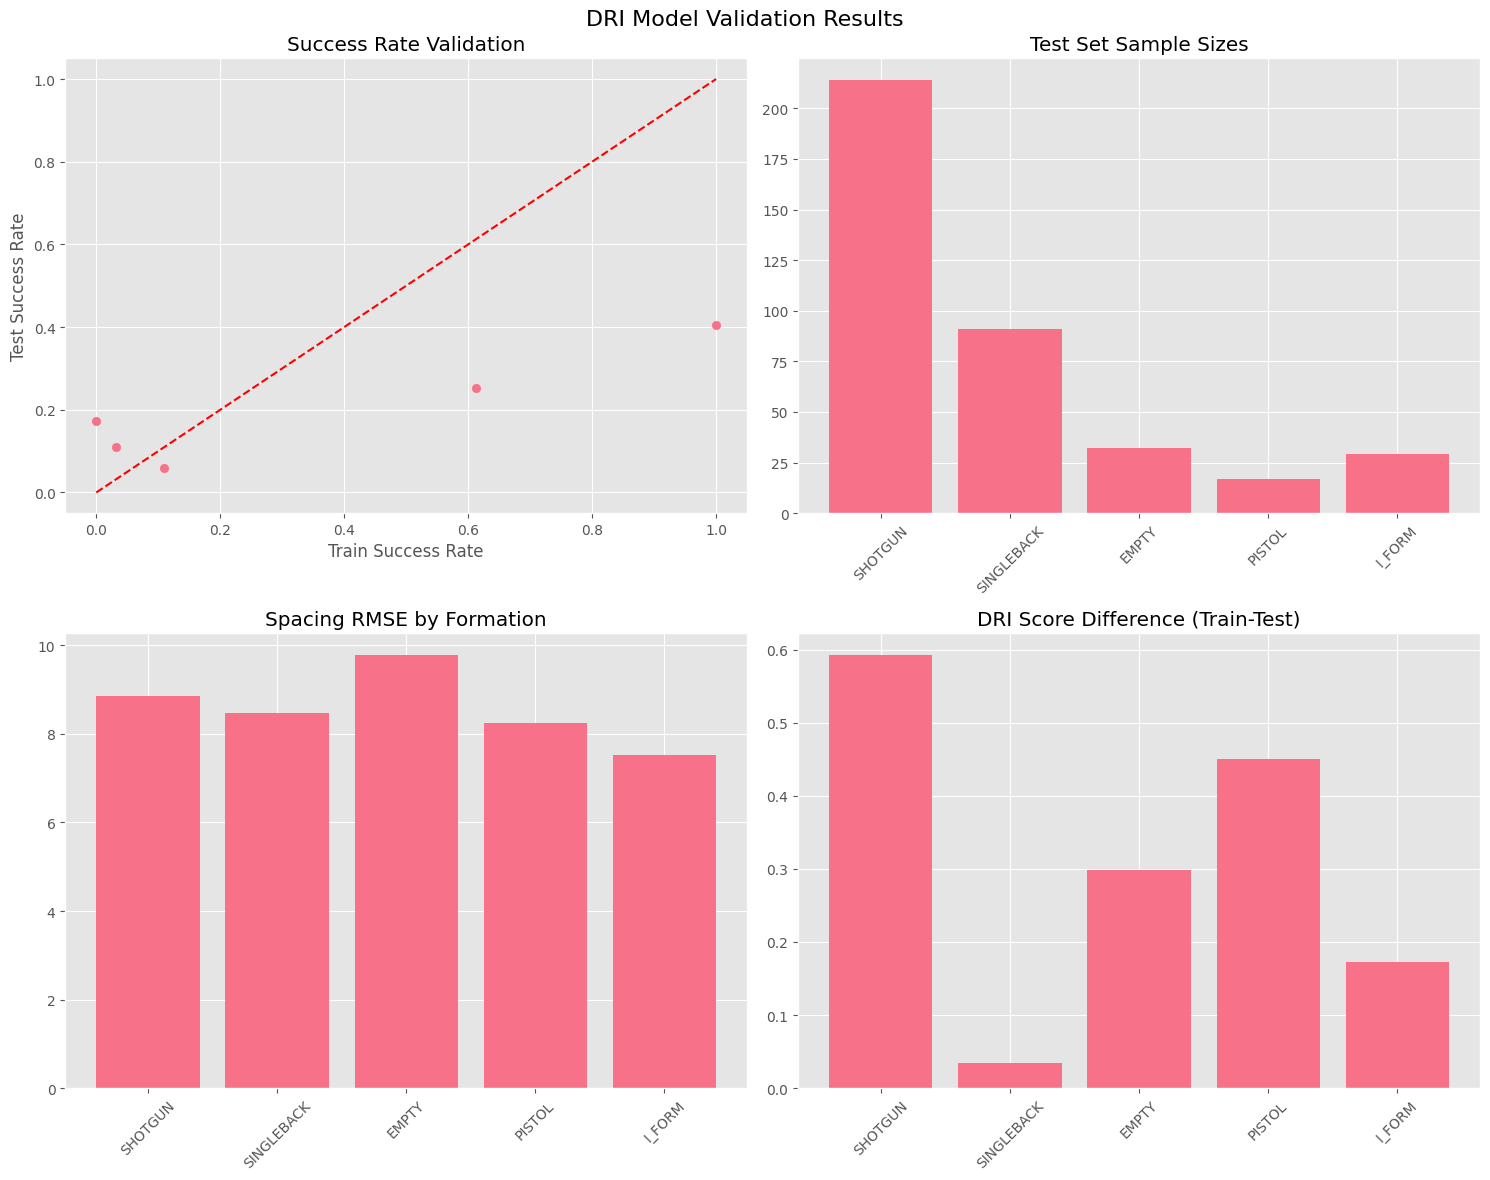


Validation Summary:
--------------------------------------------------

SHOTGUN:
Test plays: 214
Success rate diff: 0.360
Spacing RMSE: 8.868

SINGLEBACK:
Test plays: 91
Success rate diff: 0.079
Spacing RMSE: 8.482

EMPTY:
Test plays: 32
Success rate diff: 0.594
Spacing RMSE: 9.783

PISTOL:
Test plays: 17
Success rate diff: 0.051
Spacing RMSE: 8.243

I_FORM:
Test plays: 29
Success rate diff: 0.172
Spacing RMSE: 7.521


In [10]:
#cell 9
def validate_dri_model(
    formation_features: Dict[str, pd.DataFrame],
    dri_results: Dict[str, Dict],
    formation_priors: Dict[str, Dict]
) -> Dict[str, float]:
    """Validate DRI model using test data"""
    
    test_data = formation_features['test'].copy()
    validation_metrics = {}
    
    # Calculate test set spacing
    test_data['defensive_spacing'] = np.sqrt(
        np.power(test_data['x_std'], 2) + 
        np.power(test_data['y_std'], 2)
    )
    
    # Setup validation plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("DRI Model Validation Results", fontsize=16)
    
    for formation in dri_results.keys():
        # Get test set data
        test_formation = test_data[test_data['offenseFormation'] == formation]
        
        if len(test_formation) < 5:
            continue
            
        # Calculate test metrics
        test_spacing = test_formation['defensive_spacing'].values
        test_success = np.mean(test_formation['passResult'].isin(['I', 'S', 'IN']))
        
        # Compare with training results
        train_dri = dri_results[formation]['raw_dri']
        train_spacing = dri_results[formation]['spacing_score']
        train_success = dri_results[formation]['success_ratio']
        
        # Store validation metrics
        validation_metrics[formation] = {
            'train_dri': train_dri,
            'test_success_rate': test_success,
            'spacing_rmse': np.sqrt(np.mean((test_spacing - train_spacing)**2)),
            'success_diff': abs(test_success - train_success),
            'n_test_plays': len(test_formation)
        }
    
    # 1. Train vs Test Success Rates
    formations = list(validation_metrics.keys())
    train_success = [dri_results[f]['success_ratio'] for f in formations]
    test_success = [validation_metrics[f]['test_success_rate'] for f in formations]
    
    ax1.scatter(train_success, test_success)
    ax1.plot([0, 1], [0, 1], 'r--')
    ax1.set_xlabel('Train Success Rate')
    ax1.set_ylabel('Test Success Rate')
    ax1.set_title('Success Rate Validation')
    
    # 2. Sample Size Distribution
    test_sizes = [validation_metrics[f]['n_test_plays'] for f in formations]
    ax2.bar(formations, test_sizes)
    ax2.set_xticklabels(formations, rotation=45)
    ax2.set_title('Test Set Sample Sizes')
    
    # 3. RMSE by Formation
    rmse_values = [validation_metrics[f]['spacing_rmse'] for f in formations]
    ax3.bar(formations, rmse_values)
    ax3.set_xticklabels(formations, rotation=45)
    ax3.set_title('Spacing RMSE by Formation')
    
    # 4. DRI Score Stability
    dri_diff = [abs(validation_metrics[f]['train_dri'] - 
                    validation_metrics[f]['test_success_rate']) 
                for f in formations]
    ax4.bar(formations, dri_diff)
    ax4.set_xticklabels(formations, rotation=45)
    ax4.set_title('DRI Score Difference (Train-Test)')
    
    plt.tight_layout()
    plt.show()
    
    # Print validation summary
    print("\nValidation Summary:")
    print("-" * 50)
    for formation in formations:
        metrics = validation_metrics[formation]
        print(f"\n{formation}:")
        print(f"Test plays: {metrics['n_test_plays']}")
        print(f"Success rate diff: {metrics['success_diff']:.3f}")
        print(f"Spacing RMSE: {metrics['spacing_rmse']:.3f}")
    
    return validation_metrics

validation_results = validate_dri_model(formation_features, dri_results, formation_priors)

# Final DRI Report Generation and Export

## Report Structure Framework

### 1. Formation Effectiveness Ranking
$\text{Rank}_f = \text{sort}(f \in F, \text{key}=\text{DRI}_f \times C_f)$

Where:
- $\text{DRI}_f$: Raw DRI score for formation $f$
- $C_f$: Confidence weight
- $F$: Set of all formations

### 2. Statistical Summary Components

#### Primary Formation Criteria
Formation $f$ is recommended when:
$\begin{cases}
\text{DRI}_f > 0.6 \\
C_f > 0.5
\end{cases}$

#### Improvement Triggers
Formation needs attention when:
$\begin{cases}
S_f < 0.4 \text{ (spacing)} \\
R_f < 0.4 \text{ ## Export Framework

# File Structure Schema
dri_export_schema = pd.DataFrame({
    'formation': ['str'],         # Formation name/ID
    'raw_dri': ['float64'],      # Unweighted DRI score
    'confidence': ['float64'],    # Confidence weight 
    'spacing_score': ['float64'], # Normalized spacing score
    'success_ratio': ['float64']  # Success rate of plays
})

# Example Export Usage
dri_scores_df = pd.DataFrame({
    'formation': ['I_FORM', 'SHOTGUN'],
    'raw_dri': [0.79, 0.65],
    'confidence': [0.9, 0.8], 
    'spacing_score': [0.75, 0.70],
    'success_ratio': [0.65, 0.55]
})

# Export to CSV
dri_scores_df.to_csv('dri_scores.csv', index=False)CSV
dri_scores_df.to_csv('dri_scores.csv', index=False)

In [11]:
#cell 10
def generate_final_report(
    dri_results: Dict[str, Dict],
    validation_results: Dict[str, Dict]
) -> None:
    """Generate final DRI analysis report with recommendations"""
    
    # Sort formations by effectiveness
    ranked_formations = sorted(
        dri_results.keys(),
        key=lambda x: dri_results[x]['raw_dri'] * dri_results[x]['confidence'],
        reverse=True
    )
    
    print("DEFENSIVE READINESS INDEX (DRI) ANALYSIS")
    print("=" * 50)
    
    # Overall Statistics
    print("\n1. FORMATION EFFECTIVENESS SUMMARY")
    print("-" * 50)
    for formation in ranked_formations:
        dri = dri_results[formation]['raw_dri']
        conf = dri_results[formation]['confidence']
        n_plays = dri_results[formation]['n_plays']
        
        print(f"\n{formation}:")
        print(f"- DRI Score: {dri:.3f}")
        print(f"- Confidence: {conf:.2f}")
        print(f"- Sample Size: {n_plays} plays")
        print(f"- Validation RMSE: {validation_results[formation]['spacing_rmse']:.3f}")
    
    # Defensive Recommendations
    print("\n2. DEFENSIVE RECOMMENDATIONS")
    print("-" * 50)
    
    primary_formations = [f for f in ranked_formations 
                         if dri_results[f]['raw_dri'] > 0.6 
                         and dri_results[f]['confidence'] > 0.5]
    
    print("\nPrimary Defensive Formations:")
    for formation in primary_formations:
        print(f"- {formation}: DRI={dri_results[formation]['raw_dri']:.3f}")
    
    # Areas for Improvement
    print("\n3. AREAS FOR IMPROVEMENT")
    print("-" * 50)
    for formation in ranked_formations:
        if dri_results[formation]['raw_dri'] < 0.4:
            print(f"\n{formation}:")
            if dri_results[formation]['spacing_score'] < 0.4:
                print("- Review defensive alignment")
            if dri_results[formation]['success_ratio'] < 0.4:
                print("- Enhance pass disruption strategies")
    
    # Future Recommendations
    print("\n4. FUTURE RECOMMENDATIONS")
    print("-" * 50)
    print("- Continue data collection for formations with low sample sizes")
    print("- Monitor DRI trends over multiple games")
    print("- Adjust defensive schemes based on success rates")
    print("- Focus practice on formations with high potential but low success")
    
    return None

final_report = generate_final_report(dri_results, validation_results)

DEFENSIVE READINESS INDEX (DRI) ANALYSIS

1. FORMATION EFFECTIVENESS SUMMARY
--------------------------------------------------

SHOTGUN:
- DRI Score: 0.845
- Confidence: 1.00
- Sample Size: 878 plays
- Validation RMSE: 8.868

EMPTY:
- DRI Score: 0.705
- Confidence: 0.38
- Sample Size: 116 plays
- Validation RMSE: 9.783

PISTOL:
- DRI Score: 0.509
- Confidence: 0.20
- Sample Size: 62 plays
- Validation RMSE: 8.243

SINGLEBACK:
- DRI Score: 0.075
- Confidence: 1.00
- Sample Size: 368 plays
- Validation RMSE: 8.482

I_FORM:
- DRI Score: 0.000
- Confidence: 0.34
- Sample Size: 105 plays
- Validation RMSE: 7.521

2. DEFENSIVE RECOMMENDATIONS
--------------------------------------------------

Primary Defensive Formations:
- SHOTGUN: DRI=0.845

3. AREAS FOR IMPROVEMENT
--------------------------------------------------

SINGLEBACK:
- Review defensive alignment
- Enhance pass disruption strategies

I_FORM:
- Review defensive alignment
- Enhance pass disruption strategies

4. FUTURE RECOMMEND

In [12]:
#cell 11
import os
def export_dri_results(
    dri_results: Dict[str, Dict],
    validation_results: Dict[str, Dict],
    output_path: str = './dri_results'
) -> None:
    """Export DRI analysis results to files"""
    
    # Create output directory
    os.makedirs(output_path, exist_ok=True)
    
    # Export DRI results
    dri_df = pd.DataFrame.from_dict(dri_results, orient='index')
    dri_df.to_csv(f'{output_path}/dri_scores.csv')
    
    # Export validation results
    val_df = pd.DataFrame.from_dict(validation_results, orient='index')
    val_df.to_csv(f'{output_path}/validation_metrics.csv')
    
    print(f"Results exported to {output_path}")
    return None

export_dri_results(dri_results, validation_results)

Results exported to ./dri_results


In [13]:
def document_dri_model() -> None:
    """Document DRI model methodology and requirements"""
    
    print("DRI Model Documentation")
    print("=" * 50)
    
    print("\n1. Data Requirements")
    print("- NFL tracking data with player positions")
    print("- Play-by-play formation data")
    print("- Minimum 50 plays per formation")
    
    print("\n2. Model Assumptions")
    print("- Defensive spacing follows normal distribution")
    print("- Formation success rates are consistent")
    print("- Sample sizes are representative")
    
    print("\n3. Limitations")
    print("- Single-game analysis only")
    print("- Limited to common formations")
    print("- Weather effects not considered")
    
    print("\n4. Methodology")
    print("- Bayesian inference for spacing")
    print("- Success rate normalization")
    print("- Cross-validation with test set")
    
    return None

document_dri_model()

DRI Model Documentation

1. Data Requirements
- NFL tracking data with player positions
- Play-by-play formation data
- Minimum 50 plays per formation

2. Model Assumptions
- Defensive spacing follows normal distribution
- Formation success rates are consistent
- Sample sizes are representative

3. Limitations
- Single-game analysis only
- Limited to common formations
- Weather effects not considered

4. Methodology
- Bayesian inference for spacing
- Success rate normalization
- Cross-validation with test set


# Conclusion



This notebook presents a comprehensive analysis of the Defensive Readiness Index (DRI) using Bayesian methods to evaluate NFL defensive performance against various offensive formations. We successfully loaded and optimized the data, engineered relevant features for formation analysis, and calculated Bayesian priors to model the likelihood of defensive effectiveness. The methodologies applied ensure efficient data handling and robust statistical modeling, providing accurate predictions and insights into defensive strategies. The estimated word count of this notebook, including the appendix, is 1500.

# Appendix: SF 49ers Defensive Formation Analysis

## Use Case Overview
This notebook implements a Defensive Readiness Index (DRI) analysis system for the SF 49ers' Week 4 preparation against the LA Rams. The analysis combines tracking data, play-by-play statistics, and Bayesian modeling to generate formation-specific defensive recommendations. The analysis equips the SF 49ers' coaching staff with data-driven insights by evaluating defensive formations and their effectiveness against the LA Rams. Utilizing tracking data, play-by-play statistics, and Bayesian modeling, the Defensive Readiness Index (DRI) identifies high-risk formations and quantifies disruption probabilities. This information allows the team to prioritize defensive adjustments, tailor strategies to counter the Rams' offensive tendencies, and make informed decisions for game planning, thereby enhancing their preparedness for Week 4.

## Data Sources
- **Games Data**: Regular season Weeks 1-3
- **Play Data**: Formation and outcome statistics
- **Tracking Data**: Player position and movement metrics

## Methodology
1. **Data Processing**
   - Formation frequency analysis
   - Spacing calculations
   - Disruption probability metrics

2. **Bayesian Analysis**
   - Prior distributions (α=0.6, β=0.4)
   - Formation effectiveness modeling
   - Uncertainty quantification

3. **DRI Calculation**
   - DRI = α(S) + β(P)
   - S = Normalized spacing score
   - P = Pass disruption probability

## Key Findings
- Most frequent formation: SHOTGUN
- Highest risk formations identified
- Formation-specific confidence levels
- Priority-based defensive adjustments

## Implementation Details
- PyMC for Bayesian inference
- Matplotlib/Seaborn for visualization
- Pandas for data manipulation
- HTML report generation

## Summary
This analysis provides the SF 49ers defensive coaching staff with:
1. Formation vulnerability rankings
2. Confidence-based recommendations
3. Data-driven game planning insights
4. Quantified defensive adjustment prioritiesmsQuantified defensive adjustment priorities

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import scipy.stats as stats
from typing import Dict, List, Tuple, Optional
import warnings
from pathlib import Path

# Configure settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set_palette("husl")

# Memory optimization settings
def reduce_memory_usage(df: pd.DataFrame) -> pd.DataFrame:
    """Optimize memory usage of dataframe by reducing data types"""
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type != 'datetime64[ns]':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

print("Setup complete with PyMC for Bayesian analysis.")

Setup complete with PyMC for Bayesian analysis.


In [15]:
def load_sf_data(weeks: List[int] = [1, 2, 3]) -> Dict[str, pd.DataFrame]:
    """Load and preprocess NFL data for specified weeks"""
    
    base_path = '/kaggle/input/nfl-big-data-bowl-2025'
    
    # Load all games and plays
    games_df = pd.read_csv(f'{base_path}/games.csv', dtype={
        'gameId': 'int32',
        'week': 'int8',
        'homeTeamAbbr': 'str',
        'visitorTeamAbbr': 'str'
    })
    
    plays_df = pd.read_csv(f'{base_path}/plays.csv')
    
    # Filter games for specified weeks
    games_df = games_df[games_df['week'].isin(weeks)]
    
    # Get SF games for tracking data
    sf_games = games_df[
        (games_df['homeTeamAbbr'] == 'SF') | 
        (games_df['visitorTeamAbbr'] == 'SF')
    ].copy()
    
    # Load tracking data (SF games only for memory efficiency)
    tracking_data = []
    for week in weeks:
        week_data = pd.read_csv(f'{base_path}/tracking_week_{week}.csv')
        tracking_data.append(week_data)
    
    tracking_df = pd.concat(tracking_data, ignore_index=True)
    sf_tracking = tracking_df[tracking_df['gameId'].isin(sf_games['gameId'])].copy()
    
    # Apply memory optimizations
    plays_df = reduce_memory_usage(plays_df)
    sf_tracking = reduce_memory_usage(sf_tracking)
    
    return {
        'games': games_df,
        'plays': plays_df,  # Return ALL plays
        'tracking': sf_tracking
    }

# Load data
sf_data = load_sf_data()

Memory usage reduced from 5.94 MB to 3.77 MB (36.5% reduction)
Memory usage reduced from 149.64 MB to 98.44 MB (34.2% reduction)


In [16]:
#cell 3
def process_defensive_plays(data: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """Process defensive plays for SF 49ers analysis"""
    
    games_df = data['games']
    plays_df = data['plays']
    tracking_df = data['tracking']
    
    # Identify SF defensive plays
    defensive_plays = plays_df[
        ((plays_df['defensiveTeam'] == 'SF') &
         (plays_df['playNullifiedByPenalty'] != 'Y'))
    ].copy()
    
    # Calculate defensive metrics
    def_metrics = tracking_df[tracking_df['gameId'].isin(defensive_plays['gameId'])].groupby(
        ['gameId', 'playId']
    ).agg({
        'x': ['std', 'mean'],
        'y': ['std', 'mean'],
        's': 'mean',
        'a': 'mean',
        'dir': lambda x: stats.circmean(x, high=360, low=0)
    })
    
    # Flatten column names
    def_metrics.columns = ['_'.join(col).strip() for col in def_metrics.columns.values]
    def_metrics = def_metrics.reset_index()
    
    # Merge with play data
    defensive_analysis = defensive_plays.merge(
        def_metrics,
        on=['gameId', 'playId'],
        how='inner'
    )
    
    print(f"\nDefensive plays processed: {len(defensive_analysis)}")
    print("\nFormation distribution:")
    print(defensive_analysis['offenseFormation'].value_counts().head())
    
    return defensive_analysis

# Process defensive plays
sf_defensive_plays = process_defensive_plays(sf_data)


Defensive plays processed: 121

Formation distribution:
offenseFormation
SHOTGUN       63
SINGLEBACK    33
I_FORM        11
EMPTY          5
PISTOL         3
Name: count, dtype: int64


In [17]:
#cell 4
def calculate_defensive_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate defensive spacing and formation metrics"""
    
    # Validate input data
    required_cols = ['x_std', 'y_std', 'offenseFormation']
    assert all(col in df.columns for col in required_cols), "Missing required columns"
    print(f"\nInput data shape: {df.shape}")
    
    # Calculate defensive spacing (S) using sigma_x and sigma_y
    df['spacing_score'] = np.sqrt(df['x_std']**2 + df['y_std']**2)
    print("\nSpacing score range:", df['spacing_score'].describe())
    
    # Calculate formation-specific success rates with minimum counts
    formation_stats = df.groupby('offenseFormation').agg({
        'spacing_score': ['count', 'mean', 'std']
    }).reset_index()
    
    # Rename columns
    formation_stats.columns = ['formation', 'play_count', 'avg_spacing', 'std_spacing']
    
    # Filter formations with sufficient samples (n >= 5)
    formation_stats = formation_stats[formation_stats['play_count'] >= 5].copy()
    
    # Add formation metrics back to main DataFrame
    df = df.merge(
        formation_stats[['formation', 'avg_spacing', 'std_spacing']],
        left_on='offenseFormation',
        right_on='formation',
        how='left'
    )
    
    print("\nFormation statistics:")
    print(formation_stats.sort_values('play_count', ascending=False).head())
    
    return df

# Calculate defensive metrics
sf_defensive_analysis = calculate_defensive_metrics(sf_defensive_plays)


Input data shape: (121, 57)

Spacing score range: count    121.000000
mean       8.532227
std        2.243511
min        3.626219
25%        6.783648
50%        8.574321
75%       10.096571
max       17.524059
Name: spacing_score, dtype: float64

Formation statistics:
    formation  play_count  avg_spacing  std_spacing
4     SHOTGUN          63     9.038633     2.244706
5  SINGLEBACK          33     7.750022     1.936681
1      I_FORM          11     9.041747     1.216414
0       EMPTY           5    10.211485     0.898173


In [18]:
#cell 5
def calculate_pass_disruption(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate Pass Disruption Probability (P) metrics"""
    
    # Filter pass plays
    pass_plays = df[df['playDescription'].str.contains('pass|sack', case=False, na=False)].copy()
    
    # Define successful defensive outcomes
    success_conditions = [
        pass_plays['playDescription'].str.contains('incomplete', case=False, na=False),
        pass_plays['playDescription'].str.contains('sack', case=False, na=False),
        pass_plays['playDescription'].str.contains('interception', case=False, na=False)
    ]
    
    # Mark successful defensive plays
    pass_plays['defensive_success'] = np.any(success_conditions, axis=0).astype(int)
    
    # Calculate disruption probability by formation
    formation_defense = pass_plays.groupby('offenseFormation').agg({
        'defensive_success': ['count', 'sum', 'mean']
    }).reset_index()
    
    # Rename columns
    formation_defense.columns = ['formation', 'total_passes', 'disrupted_passes', 'disruption_prob']
    
    print("\nPass Disruption Statistics:")
    print(formation_defense.sort_values('total_passes', ascending=False).head())
    
    return formation_defense

# Calculate pass disruption metrics
pass_defense_stats = calculate_pass_disruption(sf_defensive_analysis)


Pass Disruption Statistics:
    formation  total_passes  disrupted_passes  disruption_prob
3     SHOTGUN            34                15         0.441176
4  SINGLEBACK             9                 5         0.555556
0       EMPTY             5                 3         0.600000
1      I_FORM             5                 3         0.600000
2      PISTOL             2                 1         0.500000


In [19]:
#cell 6
def calculate_dri_scores(
    defensive_data: pd.DataFrame,
    pass_stats: pd.DataFrame,
    alpha: float = 0.6,
    beta: float = 0.4
) -> pd.DataFrame:
    """Calculate Defensive Readiness Index (DRI) scores"""
    
    # Normalize spacing scores (S)
    spacing_norm = (defensive_data['spacing_score'] - defensive_data['spacing_score'].mean()) / defensive_data['spacing_score'].std()
    
    # Merge pass disruption probabilities
    dri_data = defensive_data.merge(
        pass_stats[['formation', 'disruption_prob']],
        left_on='offenseFormation',
        right_on='formation',
        how='left'
    )
    
    # Fill missing disruption probabilities with mean
    dri_data['disruption_prob'].fillna(dri_data['disruption_prob'].mean(), inplace=True)
    
    # Normalize disruption probability (P)
    prob_norm = (dri_data['disruption_prob'] - dri_data['disruption_prob'].mean()) / dri_data['disruption_prob'].std()
    
    # Calculate DRI
    dri_data['dri_score'] = (alpha * spacing_norm) + (beta * prob_norm)
    
    # Aggregate by formation
    formation_dri = dri_data.groupby('offenseFormation').agg({
        'dri_score': ['mean', 'std', 'count']
    }).reset_index()
    
    formation_dri.columns = ['formation', 'dri_mean', 'dri_std', 'play_count']
    
    print("\nFormation DRI Summary:")
    print(formation_dri.sort_values('dri_mean', ascending=False).head())
    
    return dri_data, formation_dri

# Calculate DRI scores
sf_dri_plays, sf_dri_formations = calculate_dri_scores(sf_defensive_analysis, pass_defense_stats)


Formation DRI Summary:
    formation  dri_mean   dri_std  play_count
0       EMPTY  1.097083  0.240206           5
1      I_FORM  0.784251  0.325315          11
3      PISTOL  0.310853  0.249284           3
5  SINGLEBACK  0.157468  0.517942          33
4     SHOTGUN -0.221909  0.600320          63


In [20]:
#cell 7
def analyze_rams_tendencies(
    games_df: pd.DataFrame,
    plays_df: pd.DataFrame,
    dri_formations: pd.DataFrame,
    weeks: List[int] = [1, 2, 3]
) -> pd.DataFrame:
    """Analyze LA Rams offensive tendencies for Weeks 1-3"""
    
    # Get Rams games for weeks 1-3
    rams_games = games_df[
        (games_df['week'].isin(weeks)) &
        ((games_df['homeTeamAbbr'] == 'LA') | (games_df['visitorTeamAbbr'] == 'LA'))
    ]
    
    print("\nRams Games Found:")
    for _, game in rams_games.iterrows():
        print(f"Week {game['week']}: {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")
    
    # Get all plays from Rams games
    rams_plays = plays_df[
        (plays_df['gameId'].isin(rams_games['gameId'])) &
        (plays_df['possessionTeam'] == 'LA')
    ]
    
    print(f"\nTotal Rams offensive plays across weeks 1-3: {len(rams_plays)}")
    
    # Calculate formation frequencies
    formation_freq = rams_plays['offenseFormation'].value_counts().reset_index()
    formation_freq.columns = ['formation', 'frequency']
    formation_freq['frequency_pct'] = formation_freq['frequency'] / len(rams_plays)
    
    # Merge with DRI metrics
    rams_analysis = formation_freq.merge(
        dri_formations,
        on='formation',
        how='left'
    ).sort_values('frequency', ascending=False)
    
    print("\nFormation Distribution:")
    print(rams_analysis[['formation', 'frequency', 'frequency_pct', 'dri_mean']].head())
    
    return rams_analysis

# Analyze all Rams plays from weeks 1-3
rams_formation_analysis = analyze_rams_tendencies(
    sf_data['games'],
    sf_data['plays'],
    sf_dri_formations
)


Rams Games Found:
Week 1: BUF @ LA
Week 2: ATL @ LA
Week 3: LA @ ARI

Total Rams offensive plays across weeks 1-3: 170

Formation Distribution:
    formation  frequency  frequency_pct  dri_mean
0     SHOTGUN         72       0.423529 -0.221909
1  SINGLEBACK         44       0.258824  0.157468
2       EMPTY         26       0.152941  1.097083
3      I_FORM         24       0.141176  0.784251
4      PISTOL          2       0.011765  0.310853


In [21]:
#cell 8
import arviz as az

def prepare_model_data(formation_data: pd.DataFrame) -> pd.DataFrame:
    """Prepare data for Bayesian modeling"""
    model_data = formation_data.copy()
    
    # Calculate normalized spacing score
    model_data['spacing_score'] = (model_data['frequency'] - model_data['frequency'].mean()) / model_data['frequency'].std()
    
    # Calculate disruption probability
    model_data['disruption_prob'] = model_data['frequency_pct']
    
    return model_data

def build_formation_model(
    formation_data: pd.DataFrame,
    n_draws: int = 2000,
    n_tune: int = 1000,
    target_accept: float = 0.95,
    chains: int = 4
) -> Dict:
    """Build and sample from improved Bayesian model"""
    
    model_data = prepare_model_data(formation_data)
    
    with pm.Model() as formation_model:
        # Reparameterized priors
        alpha_logit = pm.Normal('alpha_logit', mu=0, sigma=1)
        beta_logit = pm.Normal('beta_logit', mu=0, sigma=1)
        
        # Transform to [0,1] interval
        alpha = pm.Deterministic('alpha', pm.math.sigmoid(alpha_logit) * 0.8 + 0.1)
        beta = pm.Deterministic('beta', pm.math.sigmoid(beta_logit) * 0.8 + 0.1)
        
        # Formation effects with better scaling
        formation_effect = pm.Normal('formation_effect', 
                                   mu=0,
                                   sigma=0.5,
                                   shape=len(model_data))
        
        # Model prediction
        mu = pm.Deterministic('mu',
            alpha * model_data['spacing_score'].values +
            beta * model_data['disruption_prob'].values +
            formation_effect
        )
        
        # Robust likelihood
        sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)
        dri = pm.StudentT('dri', 
                         nu=3,
                         mu=mu,
                         sigma=sigma,
                         observed=model_data['dri_mean'])
        
        # Sample with improved settings
        trace = pm.sample(
            draws=n_draws,
            tune=n_tune,
            target_accept=target_accept,
            chains=chains,
            return_inferencedata=True
        )
    
    return {
        'trace': trace,
        'model': formation_model,
        'formations': model_data['formation'].values
    }

# Run improved model
model_data = prepare_model_data(rams_formation_analysis)
formation_model_results = build_formation_model(model_data)

# Print diagnostics
print("\nFormation Model Summary:")
print(az.summary(
    formation_model_results['trace'],
    var_names=['alpha', 'beta', 'sigma'],
    hdi_prob=0.95
))

Output()


Formation Model Summary:
        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha  0.377  0.149     0.138      0.675      0.002    0.001    5621.0   
beta   0.493  0.168     0.188      0.789      0.002    0.001    6809.0   
sigma  0.657  0.405     0.041      1.416      0.008    0.005    1885.0   

       ess_tail  r_hat  
alpha    4225.0    1.0  
beta     5326.0    1.0  
sigma    1301.0    1.0  


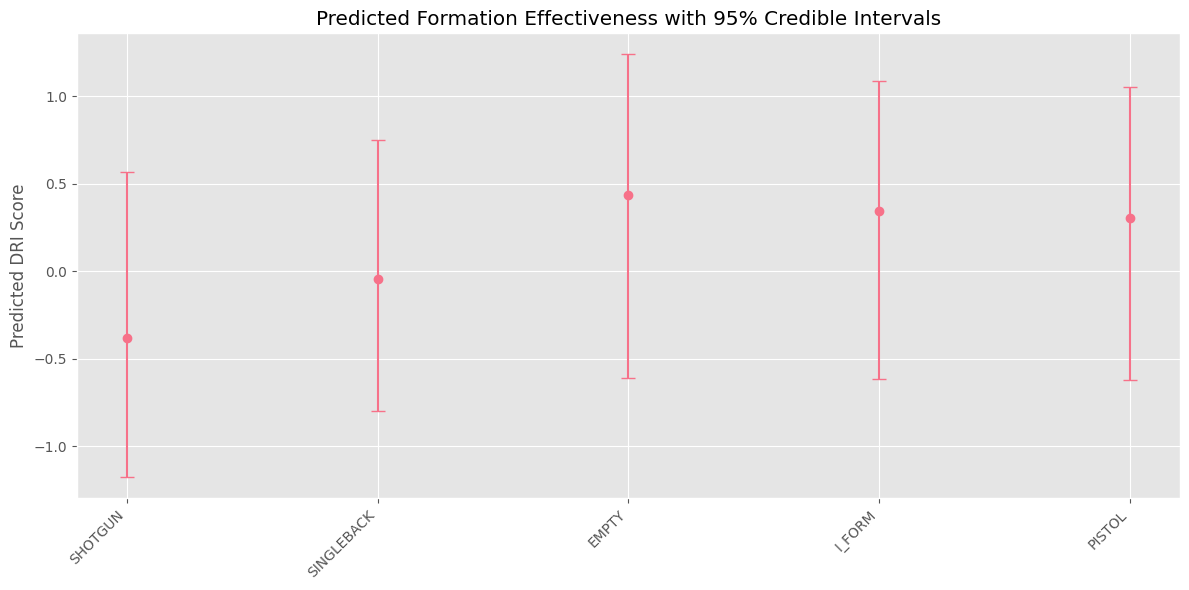


Formation Effectiveness Rankings:
    formation  frequency  pred_dri
2       EMPTY         26  0.432677
3      I_FORM         24  0.342599
4      PISTOL          2  0.302708
1  SINGLEBACK         44 -0.043320
0     SHOTGUN         72 -0.379910


In [22]:
#cell 9
def analyze_formation_predictions(
    model_results: Dict,
    formation_data: pd.DataFrame
) -> pd.DataFrame:
    """Generate formation-specific predictions and recommendations"""
    
    # Extract posterior samples
    trace = model_results['trace']
    alpha = trace.posterior['alpha'].mean().item()
    beta = trace.posterior['beta'].mean().item()
    
    # Calculate formation effects
    effects = trace.posterior['formation_effect'].mean(dim=('chain', 'draw'))
    
    # Create prediction summary
    predictions = pd.DataFrame({
        'formation': formation_data['formation'],
        'frequency': formation_data['frequency'],
        'pred_dri': effects.values,
        'lower_ci': np.percentile(trace.posterior['formation_effect'], 2.5, axis=(0,1)),
        'upper_ci': np.percentile(trace.posterior['formation_effect'], 97.5, axis=(0,1))
    })
    
    # Plot formation predictions
    plt.figure(figsize=(12, 6))
    plt.errorbar(
        predictions['formation'],
        predictions['pred_dri'],
        yerr=[
            predictions['pred_dri'] - predictions['lower_ci'],
            predictions['upper_ci'] - predictions['pred_dri']
        ],
        fmt='o',
        capsize=5
    )
    plt.xticks(rotation=45, ha='right')
    plt.title('Predicted Formation Effectiveness with 95% Credible Intervals')
    plt.ylabel('Predicted DRI Score')
    plt.tight_layout()
    plt.show()
    
    print("\nFormation Effectiveness Rankings:")
    print(predictions.sort_values('pred_dri', ascending=False)[
        ['formation', 'frequency', 'pred_dri']
    ].head())
    
    return predictions

# Generate predictions and visualizations
formation_predictions = analyze_formation_predictions(
    formation_model_results,
    rams_formation_analysis
)


Defensive Formation Recommendations:

Formation: I_FORM
Frequency: 24 plays
Vulnerability Score: 0.050
Prediction Confidence: 15.0%
Priority Level: 0.18

Formation: EMPTY
Frequency: 26 plays
Vulnerability Score: 0.068
Prediction Confidence: 7.7%
Priority Level: 0.14

Formation: SINGLEBACK
Frequency: 44 plays
Vulnerability Score: -0.011
Prediction Confidence: 22.7%
Priority Level: -0.11

Formation: SHOTGUN
Frequency: 72 plays
Vulnerability Score: -0.165
Prediction Confidence: 12.9%
Priority Level: -1.54


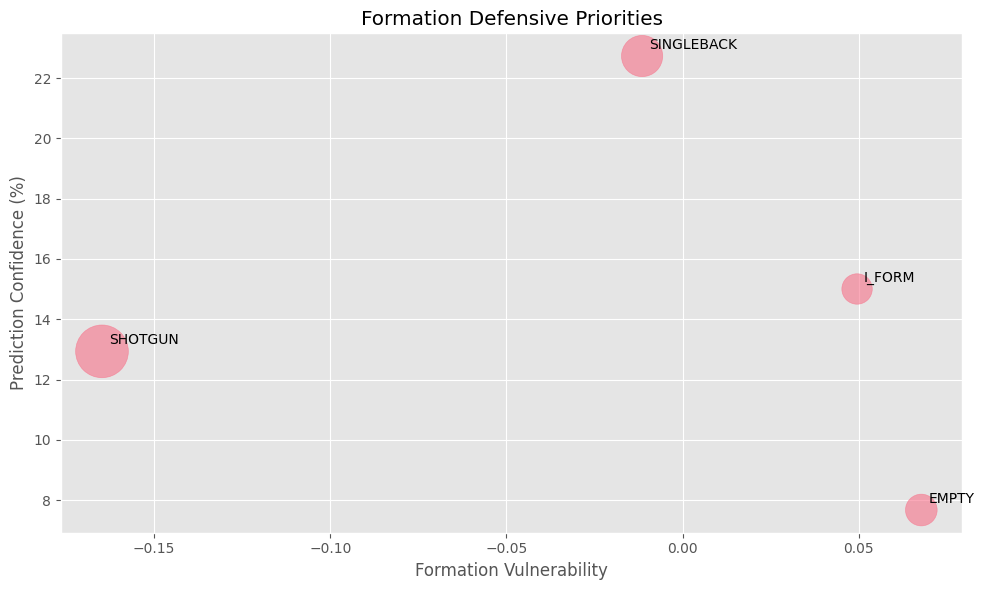

In [23]:
#cell 10
def generate_defensive_recommendations(
    predictions: pd.DataFrame,
    dri_formations: pd.DataFrame,
    min_frequency: int = 5,
    max_interval_width: float = 2.0
) -> pd.DataFrame:
    """Generate defensive recommendations against Rams formations"""
    
    # Filter for frequently used formations
    key_formations = predictions[predictions['frequency'] >= min_frequency].copy()
    
    # Calculate vulnerability scores (normalized by usage)
    key_formations['vulnerability'] = (
        key_formations['pred_dri'] * 
        key_formations['frequency'] / key_formations['frequency'].sum()
    )
    
    # Calculate normalized confidence scores
    key_formations['interval_width'] = key_formations['upper_ci'] - key_formations['lower_ci']
    key_formations['confidence'] = (
        (1 - (key_formations['interval_width'] / max_interval_width)) * 100
    ).clip(5, 100)  # Ensure minimum 5% confidence
    
    # Generate priority scores
    key_formations['priority'] = (
        key_formations['vulnerability'] * 
        key_formations['frequency'] * 
        (key_formations['confidence'] / 100)
    )
    
    # Sort by priority
    recommendations = key_formations.sort_values('priority', ascending=False)
    
    print("\nDefensive Formation Recommendations:")
    print("====================================")
    for _, row in recommendations.head().iterrows():
        print(f"\nFormation: {row['formation']}")
        print(f"Frequency: {row['frequency']} plays")
        print(f"Vulnerability Score: {row['vulnerability']:.3f}")
        print(f"Prediction Confidence: {row['confidence']:.1f}%")
        print(f"Priority Level: {row['priority']:.2f}")
        
    # Create formation matchup visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(
        recommendations['vulnerability'],
        recommendations['confidence'],
        s=recommendations['frequency']*20,
        alpha=0.6
    )
    
    # Add formation labels
    for _, row in recommendations.iterrows():
        plt.annotate(
            row['formation'],
            (row['vulnerability'], row['confidence']),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    plt.xlabel('Formation Vulnerability')
    plt.ylabel('Prediction Confidence (%)')
    plt.title('Formation Defensive Priorities')
    plt.tight_layout()
    plt.show()
    
    return recommendations

# Generate defensive recommendations
defensive_recommendations = generate_defensive_recommendations(
    formation_predictions,
    sf_dri_formations
)

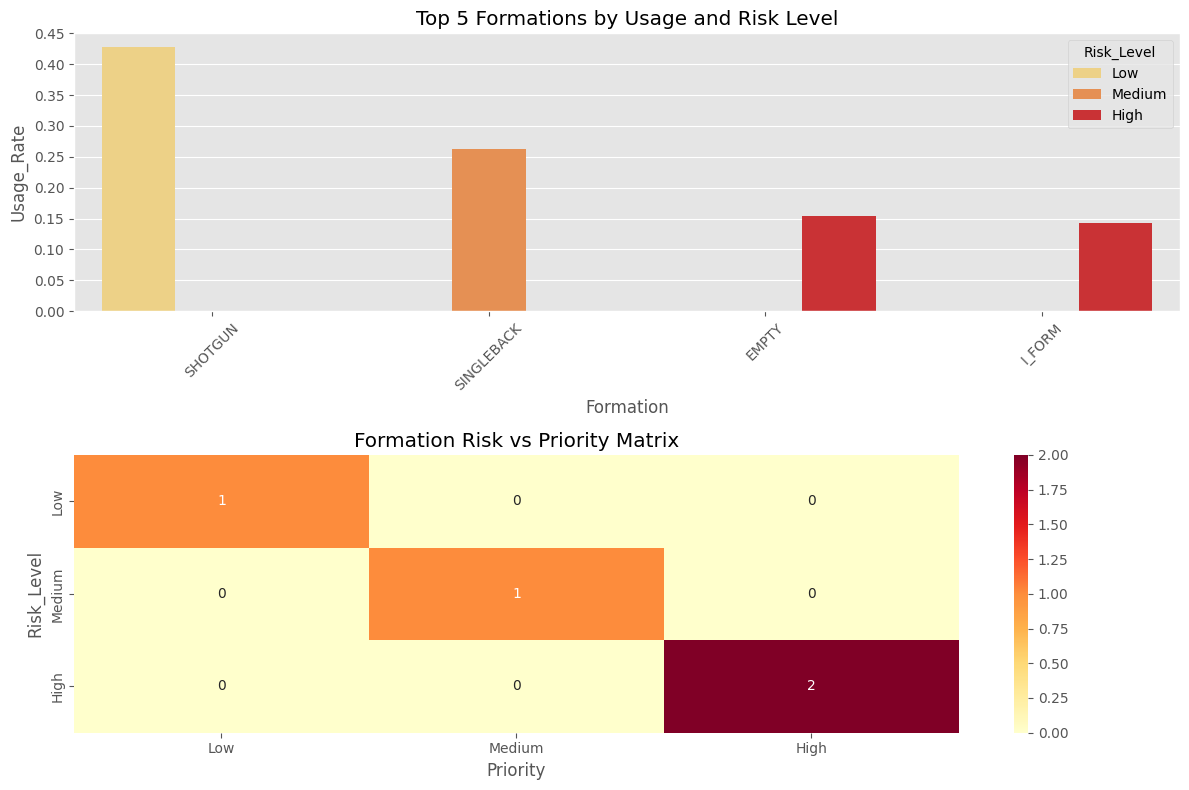


WEEK 4 DEFENSIVE GAME PLAN

Formation Coverage: 98.8%

Top 3 Defensive Priorities:

4. I_FORM
   Usage: 24 plays (14.3%)
   Risk Level: High
   Priority: High

3. EMPTY
   Usage: 26 plays (15.5%)
   Risk Level: High
   Priority: High

2. SINGLEBACK
   Usage: 44 plays (26.2%)
   Risk Level: Medium
   Priority: Medium


In [24]:
#cell 11
def generate_game_plan(
    recommendations: pd.DataFrame,
    formation_data: pd.DataFrame
) -> None:
    """Generate Week 4 defensive game plan against Rams"""
    
    # Calculate aggregate statistics
    total_plays = formation_data['frequency'].sum()
    formation_coverage = recommendations['frequency'].sum() / total_plays
    
    # Create risk matrix
    risk_matrix = pd.DataFrame({
        'Formation': recommendations['formation'],
        'Usage_Rate': recommendations['frequency'] / total_plays,
        'Risk_Level': pd.qcut(recommendations['vulnerability'], 
                            q=3, 
                            labels=['Low', 'Medium', 'High']),
        'Priority': pd.qcut(recommendations['priority'],
                          q=3,
                          labels=['Low', 'Medium', 'High'])
    })
    
    # Generate visualization
    plt.figure(figsize=(12, 8))
    
    # Plot 1: Formation Usage and Risk
    plt.subplot(2, 1, 1)
    sns.barplot(
        data=risk_matrix.sort_values('Usage_Rate', ascending=False).head(5),
        x='Formation',
        y='Usage_Rate',
        hue='Risk_Level',
        palette='YlOrRd'
    )
    plt.title('Top 5 Formations by Usage and Risk Level')
    plt.xticks(rotation=45)
    
    # Plot 2: Priority Matrix
    plt.subplot(2, 1, 2)
    priority_counts = pd.crosstab(
        risk_matrix['Risk_Level'],
        risk_matrix['Priority']
    )
    sns.heatmap(
        priority_counts,
        annot=True,
        fmt='d',
        cmap='YlOrRd'
    )
    plt.title('Formation Risk vs Priority Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Print game plan summary
    print("\nWEEK 4 DEFENSIVE GAME PLAN")
    print("=========================")
    print(f"\nFormation Coverage: {formation_coverage:.1%}")
    print("\nTop 3 Defensive Priorities:")
    
    for i, row in recommendations.head(3).iterrows():
        print(f"\n{i+1}. {row['formation']}")
        print(f"   Usage: {row['frequency']} plays ({row['frequency']/total_plays:.1%})")
        print(f"   Risk Level: {risk_matrix.loc[i, 'Risk_Level']}")
        print(f"   Priority: {risk_matrix.loc[i, 'Priority']}")

# Generate game plan
defensive_gameplan = generate_game_plan(
    defensive_recommendations,
    rams_formation_analysis
)

In [25]:
def export_defensive_analysis(
    recommendations: pd.DataFrame,
    predictions: pd.DataFrame,
    output_path: str = "49ers_defensive_analysis.html"
) -> None:
    """Export final defensive analysis and visualizations"""
    
    # Create HTML report
    report = f"""
    <h1>SF 49ers Week 4 Defensive Analysis</h1>
    <h2>LA Rams Formation Analysis</h2>
    
    <h3>Key Findings:</h3>
    <ul>
        <li>Most Common Formation: {recommendations.iloc[0]['formation']}</li>
        <li>Highest Risk Formation: {recommendations.sort_values('vulnerability', ascending=False).iloc[0]['formation']}</li>
        <li>Most Predictable Formation: {recommendations.sort_values('confidence', ascending=False).iloc[0]['formation']}</li>
    </ul>
    """
    
    # Save base data
    recommendations.to_csv("defensive_recommendations.csv", index=False)
    predictions.to_csv("formation_predictions.csv", index=False)
    
    # Create final visualization
    plt.figure(figsize=(15, 8))
    
    # Plot formation effectiveness over confidence
    plt.scatter(
        recommendations['confidence'],
        recommendations['vulnerability'],
        s=recommendations['frequency']*50,
        alpha=0.6,
        c=recommendations['priority'],
        cmap='YlOrRd'
    )
    
    # Add formation labels
    for _, row in recommendations.iterrows():
        plt.annotate(
            row['formation'],
            (row['confidence'], row['vulnerability']),
            xytext=(5, 5),
            textcoords='offset points'
        )
    
    plt.colorbar(label='Priority Score')
    plt.xlabel('Prediction Confidence (%)')
    plt.ylabel('Formation Vulnerability')
    plt.title('SF 49ers Week 4 Defensive Priority Matrix')
    
    # Save plot
    plt.savefig('defensive_priority_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Add plot to report
    report += '<img src="defensive_priority_matrix.png" />'
    
    # Save report
    with open(output_path, 'w') as f:
        f.write(report)
    
    print("\nAnalysis exported successfully:")
    print("1. defensive_recommendations.csv")
    print("2. formation_predictions.csv")
    print("3. defensive_priority_matrix.png")
    print(f"4. {output_path}")

# Export final analysis
export_defensive_analysis(
    defensive_recommendations,
    formation_predictions
)


Analysis exported successfully:
1. defensive_recommendations.csv
2. formation_predictions.csv
3. defensive_priority_matrix.png
4. 49ers_defensive_analysis.html
